In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from util import get_normalized_data
from sklearn.utils import shuffle

In [6]:
class HiddenLayer(object):
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) * np.sqrt(2.0 / M1)
        b = np.zeros(M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

In [7]:
class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep

    def fit(self, X, Y, lr=1e-4, mu=0.9, decay=0.9, epochs=15, batch_sz=100, split=True, print_every=20):
        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int64)
        if split:
            Xvalid, Yvalid = X[-1000:], Y[-1000:]
            X, Y = X[:-1000], Y[:-1000]
        else:
            Xvalid, Yvalid = X, Y

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W = np.random.randn(M1, K) * np.sqrt(2.0 / M1)
        b = np.zeros(K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up tensorflow functions and variables
        inputs = tf.placeholder(tf.float32, shape=(None, D), name='inputs')
        labels = tf.placeholder(tf.int64, shape=(None,), name='labels')
        logits = self.forward(inputs)

        cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=logits,
                labels=labels
            )
        )
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        # train_op = tf.train.MomentumOptimizer(lr, momentum=mu).minimize(cost)
        # train_op = tf.train.AdamOptimizer(lr).minimize(cost)
        prediction = self.predict(inputs)

        # validation cost will be calculated separately since nothing will be dropped
        test_logits = self.forward_test(inputs)
        test_cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=test_logits,
                labels=labels
            )
        )

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                print("epoch:", i, "n_batches:", n_batches)
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={inputs: Xbatch, labels: Ybatch})

                    if j % print_every == 0:
                        c = session.run(test_cost, feed_dict={inputs: Xvalid, labels: Yvalid})
                        p = session.run(prediction, feed_dict={inputs: Xvalid})
                        costs.append(c)
                        e = error_rate(Yvalid, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        plt.plot(costs)
        plt.show()

    def forward(self, X):
        # tf.nn.dropout scales inputs by 1/p_keep
        # therefore, during test time, we don't have to scale anything
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z, self.W) + self.b

    def forward_test(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward_test(X)
        return tf.argmax(pY, 1)

In [8]:
def error_rate(p, t):
    return np.mean(p != t)


def relu(a):
    return a * (a > 0)

Reading in and transforming data...
epoch: 0 n_batches: 410
i: 0 j: 0 nb: 410 cost: 2.82721 error rate: 0.894
i: 0 j: 20 nb: 410 cost: 2.61521 error rate: 0.869
i: 0 j: 40 nb: 410 cost: 2.15485 error rate: 0.703
i: 0 j: 60 nb: 410 cost: 1.55331 error rate: 0.448
i: 0 j: 80 nb: 410 cost: 1.00549 error rate: 0.279
i: 0 j: 100 nb: 410 cost: 0.685967 error rate: 0.195
i: 0 j: 120 nb: 410 cost: 0.521731 error rate: 0.16
i: 0 j: 140 nb: 410 cost: 0.42368 error rate: 0.121
i: 0 j: 160 nb: 410 cost: 0.371012 error rate: 0.11
i: 0 j: 180 nb: 410 cost: 0.3457 error rate: 0.101
i: 0 j: 200 nb: 410 cost: 0.318655 error rate: 0.098
i: 0 j: 220 nb: 410 cost: 0.30196 error rate: 0.091
i: 0 j: 240 nb: 410 cost: 0.271124 error rate: 0.086
i: 0 j: 260 nb: 410 cost: 0.256036 error rate: 0.087
i: 0 j: 280 nb: 410 cost: 0.243512 error rate: 0.078
i: 0 j: 300 nb: 410 cost: 0.231277 error rate: 0.075
i: 0 j: 320 nb: 410 cost: 0.222136 error rate: 0.066
i: 0 j: 340 nb: 410 cost: 0.220109 error rate: 0.067
i: 

i: 7 j: 120 nb: 410 cost: 0.119149 error rate: 0.035
i: 7 j: 140 nb: 410 cost: 0.115666 error rate: 0.037
i: 7 j: 160 nb: 410 cost: 0.119708 error rate: 0.041
i: 7 j: 180 nb: 410 cost: 0.109258 error rate: 0.038
i: 7 j: 200 nb: 410 cost: 0.120156 error rate: 0.041
i: 7 j: 220 nb: 410 cost: 0.11572 error rate: 0.038
i: 7 j: 240 nb: 410 cost: 0.111078 error rate: 0.038
i: 7 j: 260 nb: 410 cost: 0.112086 error rate: 0.037
i: 7 j: 280 nb: 410 cost: 0.113096 error rate: 0.036
i: 7 j: 300 nb: 410 cost: 0.122247 error rate: 0.042
i: 7 j: 320 nb: 410 cost: 0.120139 error rate: 0.04
i: 7 j: 340 nb: 410 cost: 0.127476 error rate: 0.039
i: 7 j: 360 nb: 410 cost: 0.122945 error rate: 0.041
i: 7 j: 380 nb: 410 cost: 0.115428 error rate: 0.032
i: 7 j: 400 nb: 410 cost: 0.130013 error rate: 0.036
epoch: 8 n_batches: 410
i: 8 j: 0 nb: 410 cost: 0.132988 error rate: 0.034
i: 8 j: 20 nb: 410 cost: 0.116538 error rate: 0.032
i: 8 j: 40 nb: 410 cost: 0.113489 error rate: 0.035
i: 8 j: 60 nb: 410 cost: 0.1

i: 14 j: 220 nb: 410 cost: 0.121841 error rate: 0.033
i: 14 j: 240 nb: 410 cost: 0.113488 error rate: 0.03
i: 14 j: 260 nb: 410 cost: 0.119508 error rate: 0.028
i: 14 j: 280 nb: 410 cost: 0.10811 error rate: 0.029
i: 14 j: 300 nb: 410 cost: 0.111424 error rate: 0.03
i: 14 j: 320 nb: 410 cost: 0.113026 error rate: 0.026
i: 14 j: 340 nb: 410 cost: 0.121129 error rate: 0.029
i: 14 j: 360 nb: 410 cost: 0.117037 error rate: 0.033
i: 14 j: 380 nb: 410 cost: 0.108878 error rate: 0.035
i: 14 j: 400 nb: 410 cost: 0.109882 error rate: 0.031


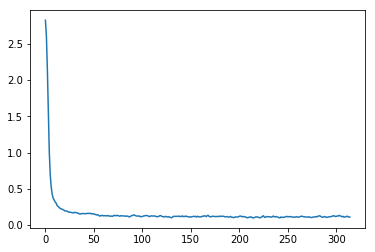

In [9]:
# step 1: get the data and define all the usual variables
X, Y = get_normalized_data()

ann = ANN([500, 300], [0.8, 0.5, 0.5])
ann.fit(X, Y)